In [39]:
import pandas as pd
import os, glob, tqdm, time

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
mpl.rcParams['font.family'] = 'monospace'
import seaborn as sns

COLORS = ['#FBC14B', '#1D5B79',  '#F08000', '#468B97',  '#870058', '#EF6262', '#74A57F' ]
sns.set_palette(sns.color_palette(COLORS))
sns.color_palette(COLORS)

[(0.984313725490196, 0.7568627450980392, 0.29411764705882354),
 (0.11372549019607843, 0.3568627450980392, 0.4745098039215686),
 (0.9411764705882353, 0.5019607843137255, 0.0),
 (0.27450980392156865, 0.5450980392156862, 0.592156862745098),
 (0.5294117647058824, 0.0, 0.34509803921568627),
 (0.9372549019607843, 0.3843137254901961, 0.3843137254901961),
 (0.4549019607843137, 0.6470588235294118, 0.4980392156862745)]

# Data Preparation and Collection

### Project Euler problems
- solutions: https://www.kaggle.com/datasets/dheerajmpai/projecteuler?select=Solutions.md.txt
- problem set: https://www.kaggle.com/datasets/patrickgendotti/project-euler-full-problem-set?resource=download

In [49]:
# Load in the solutions
with open('solutions.txt', 'r') as f:
    solutions = f.read()
solutions = solutions.split('eulersolutionsfr/\n')[1]
solutions_df = pd.DataFrame([i.split('. ') for i in solutions.split('\n')])
solutions_df.columns=['qnum', 'ans']
solutions_df = solutions_df[:830]
solutions_df.qnum = solutions_df.qnum.apply(lambda x: int(x.split('.')[0]))

# Load in the problems
problems_df = pd.read_csv('problems.csv')
problems_df = problems_df.rename(columns={'id': 'qnum'})

# Merge with the solutions
problems_df = problems_df.merge(solutions_df, on='qnum')

# Add len metadata
problems_df['len_content'] = problems_df.html_content.apply(lambda x: len(x))

In [52]:
problems_df.head()

,qnum,title,subtitle,content,html_content,release_date,solved_by_count,difficulty,ans,len_content
0,1,Multiples of 3 or 5,Problem 1,\nIf we list all the natural numbers below 10 ...,<p>If we list all the natural numbers below 10...,2001-10-05T18:00:00,970054,5,233168,200
1,2,Even Fibonacci numbers,Problem 2,\nEach new term in the Fibonacci sequence is g...,<p>Each new term in the Fibonacci sequence is ...,2001-10-19T18:00:00,774340,5,4613732,348
2,3,Largest prime factor,Problem 3,"\nThe prime factors of 13195 are 5, 7, 13 and ...","<p>The prime factors of 13195 are 5, 7, 13 and...",2001-11-02T18:00:00,557877,5,6857,126
3,4,Largest palindrome product,Problem 4,\nA palindromic number reads the same both way...,\n<p>A palindromic number reads the same both ...,2001-11-16T18:00:00,493994,5,906609,224
4,5,Smallest multiple,Problem 5,\n2520 is the smallest number that can be divi...,<p>2520 is the smallest number that can be div...,2001-11-30T18:00:00,497316,5,232792560,267


### GPT-4 prompting

In [54]:
import tqdm
import openai
openai.api_key = os.environ["OPENAI_API_KEY"]

In [55]:
def translate_to_language(text, language):
    if language=='English':
        return text
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "user", "content": f"""Translate the following text into {language}. Then, append the instruction to specify just the numerical answer at the end followed by the `∴` symbol.\n\n{text}"""},
        ],
    )
    
    return response['choices'][0]['message']['content']

def solve_problem(translated_q):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "user", "content": translated_q}
        ],
    )
    
    return response['choices'][0]['message']['content']

#### English only

In [ ]:
results = []
language='English'

# Subset of questions varying across difficulty levels
for qnum in [731, 485, 491, 62, 206, 76]:
    for run in tqdm.tqdm(range(5)):
        text = problems_df.loc[qnum-1, 'content']
        response = solve_problem(text)
        results.append({
            'qnum': qnum,
            'run': run,
            'language': language,
            'translated_q': text,
            'response': response,
        })
        time.sleep(5)

pd.DataFrame(results).to_csv(f'gpt4_results/englishonly-results.csv', index=False)

#### 16 languages

In [ ]:
languages = ['English', 'Portuguese', 
             'Korean', 'Chinese (Simplified)', 'Chinese (Traditional)', 
             'Modern Standard Arabic', 'Russian',
            'Spanish', 'German', 'Hindi', 'Bengali', 'Urdu',
             'Amharic', 'Armenian', 'Burmese', 'Farsi'
            ]
qnums = [1, 3, 205, 206, 357, 493, 500, 686]

In [ ]:
results = []
for qnum in qnums:
    print(f'QNUM: {qnum}')
    for language in languages:
        print(language)
        if language in langs_exclude: 
            print('SKIPING', language)
            continue
        for run in tqdm.tqdm(range(5)):
            text = problems_df.loc[qnum-1, 'content']
            translated_q = translate_to_language(text, language)
            time.sleep(5)
            response = solve_problem(translated_q)
            results.append({
                'qnum': qnum,
                'run': run,
                'language': language,
                'translated_q': translated_q,
                'response': response
            })
            time.sleep(5)
pd.DataFrame(results).to_csv(f'gpt4_results/16langs-results.csv', index=False)

I combined the gpt4_results dataframes into a single `project_euler_gpt4_responses.csv`.

# Load in data

In [15]:
# GPT-4's responses
df = pd.read_csv('project_euler_gpt4_responses.csv')

In [16]:
df.sample(5)

,qnum,run,language,translated_q,response,score
1002,808,2,Chinese (Simplified),169和961都是质数的平方。169是961的反转。\n\n如果一个数字满足以下条件，我们就...,这个问题实际上是编程问题，因为它需要寻找和计算特定数学模式的一系列数字。因此，手动找出前50...,fail
53,1,2,Burmese,3 သို့မဟုတ် 5 နှစ်ခုချင်းစီတိုက်စစ်တဲ့ 10 အောက...,ဤပြဿနာကို ဖော်ပြရန်အတွက် အင်္ဂလိပ်ဘာသာပေါင်းခြ...,fail
682,493,3,Armenian,Տեսակավոր 70 գույների գնդակները տեղադրվում են ...,21.2109826620,fail
967,725,4,Spanish,Un número en el que un dígito es la suma de lo...,Este es un problema del proyecto Euler (proble...,fail
595,485,2,Portuguese,Deixe d(n) ser o número de divisores de n.\nDe...,A resposta para essa pergunta é extremamente c...,fail


# Article Analyses

In [21]:
qnum2soln = {k:v for k,v in zip(problems_df.qnum.values, problems_df.ans.values)}
qnum2difficulty = {k:v for k,v in zip(problems_df.qnum.values, problems_df.difficulty.values)}


diff2color = {
    5: COLORS[6],
    10: COLORS[0],
    15: COLORS[4],
}

### Project Euler Problems analysis

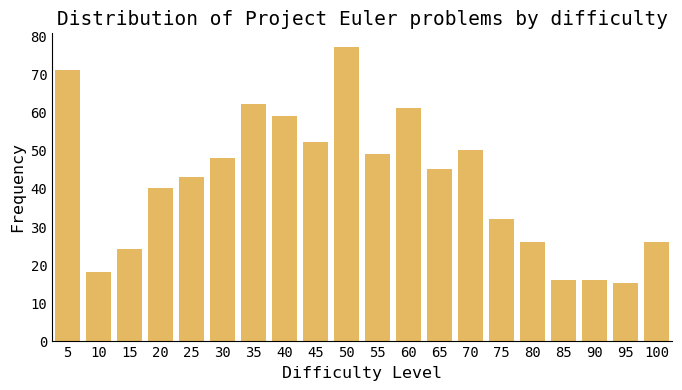

In [45]:
# Grouping the data by 'difficulty' and counting the number of problems for each difficulty level
difficulty_counts = problems_df.groupby('difficulty').size().reset_index(name='count')

# Plotting using seaborn
plt.figure(figsize=(8,4))
sns.barplot(data=difficulty_counts, x='difficulty', y='count', color=COLORS[0])
sns.despine(top=True, right=True)

plt.ylabel('Frequency', size=12)
plt.xlabel('Difficulty Level', size=12)
plt.tick_params(axis='both', which='both', length=0)

plt.title('Distribution of Project Euler problems by difficulty', size=14)

plt.show()

### English only

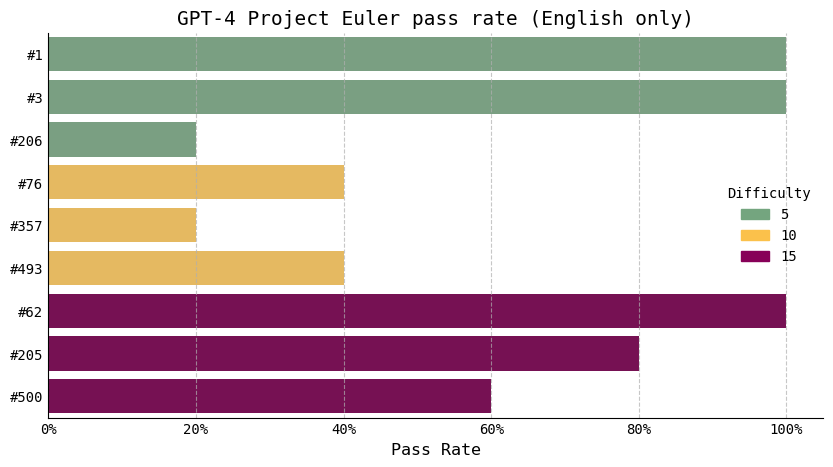

In [24]:
all_qnums = sorted([3, 206, 493, 62, 500, 491, 731, 485, 365, 142, 725, 76])

# Filter the dataframe
df_filtered = df[(df.language == 'English') 
                 & (df.score == 'pass')
#                  & (df.qnum.isin(all_qnums))
                ]\
    .reset_index(drop=True)

# Calculate the normalized counts
normalized_counts = df_filtered['qnum'].value_counts() / 5
# normalized_counts = normalized_counts.reindex(all_qnums, fill_value=0)

data = normalized_counts.reset_index()
data.columns=['qnum', '%']
data['difficulty'] = data.qnum.apply(lambda x: qnum2difficulty[x])
data['ylabel'] = data.apply(lambda x: f"#{int(x.qnum)}", axis=1)
# data['ylabel'] = data.apply(lambda x: f"#{int(x.qnum)} \n(difficulty: {int(x.difficulty)})", axis=1)

data = data.sort_values(by=['difficulty', 'qnum'])

difficulty_colors = data['difficulty'].map(diff2color)



plt.figure(figsize=(10, 5))
barplot = sns.barplot(data=data, x='%', y='ylabel', palette=difficulty_colors)
        
plt.xlabel('Pass Rate', size=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(top=True, right=True)
plt.tick_params(axis='both', which='both', length=0)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))

legend_labels = [5, 10, 15]
legend_colors = diff2color.values()
legend_patches = [Patch(color=color, label=str(label)) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, title="Difficulty", loc="center right", frameon=False)


plt.title('GPT-4 Project Euler pass rate (English only)', size=14)
plt.show()

### 16 languages

In [26]:
def plot_stacked_barplot(df, colors, figsize=(10,4)):
    
    # Calculate the pass/fail percentages
    grouped = df.groupby(['language', 'score']).size().unstack().fillna(0)
    grouped['total'] = grouped.sum(axis=1)
    grouped['% Pass'] = grouped['pass'] / grouped['total']
    grouped['% Fail'] = 1 - grouped['% Pass']

    grouped = grouped.reset_index().sort_values(by='pass')
    grouped.plot(x='language', 
                 y=['% Pass', '% Fail'], 
                 figsize=figsize,
                 kind='barh', 
                 stacked=True,
                 color=colors
                )
    plt.ylabel('')
    plt.xlabel('Pass Rate', size=12)
    plt.xticks(size=11)
    plt.yticks(size=11)
    plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='x')

    plt.tick_params(axis='both', which='both', length=0)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
    
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.legend(
        frameon=False,
        ncol=2,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        fontsize=12
    )
    return plt
    

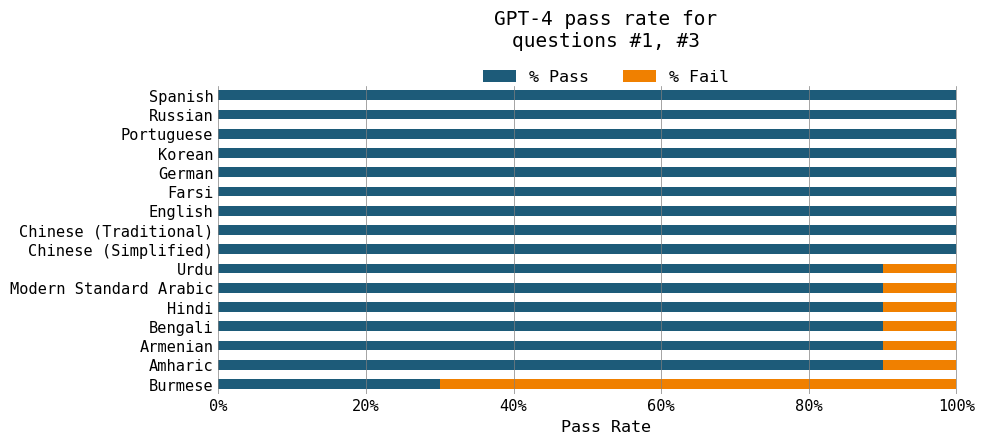

In [27]:
qnums_16_langs = [1,3]
plt = plot_stacked_barplot(df[df.qnum.isin(qnums_16_langs)], COLORS[1:3])
plt.title('GPT-4 pass rate for\nquestions #1, #3', y=1.1, size=14)
plt.show()

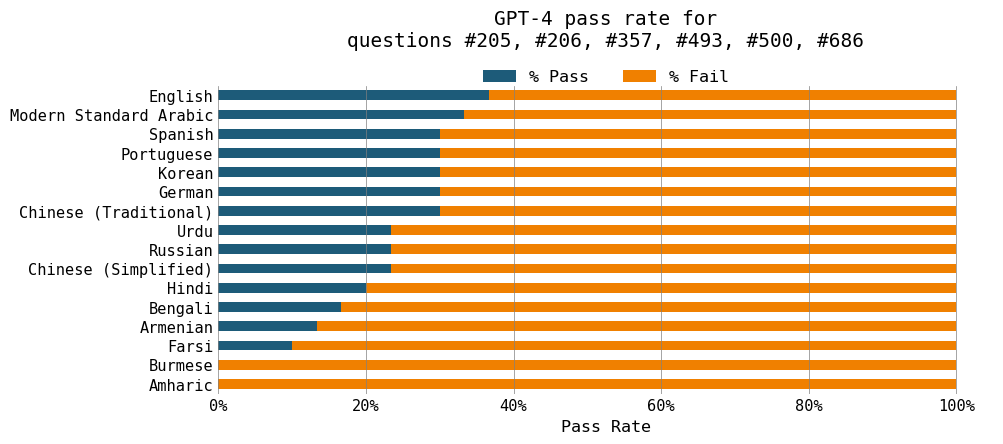

In [28]:
qnums_16_langs = [493, 500, 206, 357, 205, 686]

plt = plot_stacked_barplot(df[df.qnum.isin(qnums_16_langs)], COLORS[1:3])
plt.title('GPT-4 pass rate for\nquestions #205, #206, #357, #493, #500, #686', y=1.1, size=14)
plt.show()

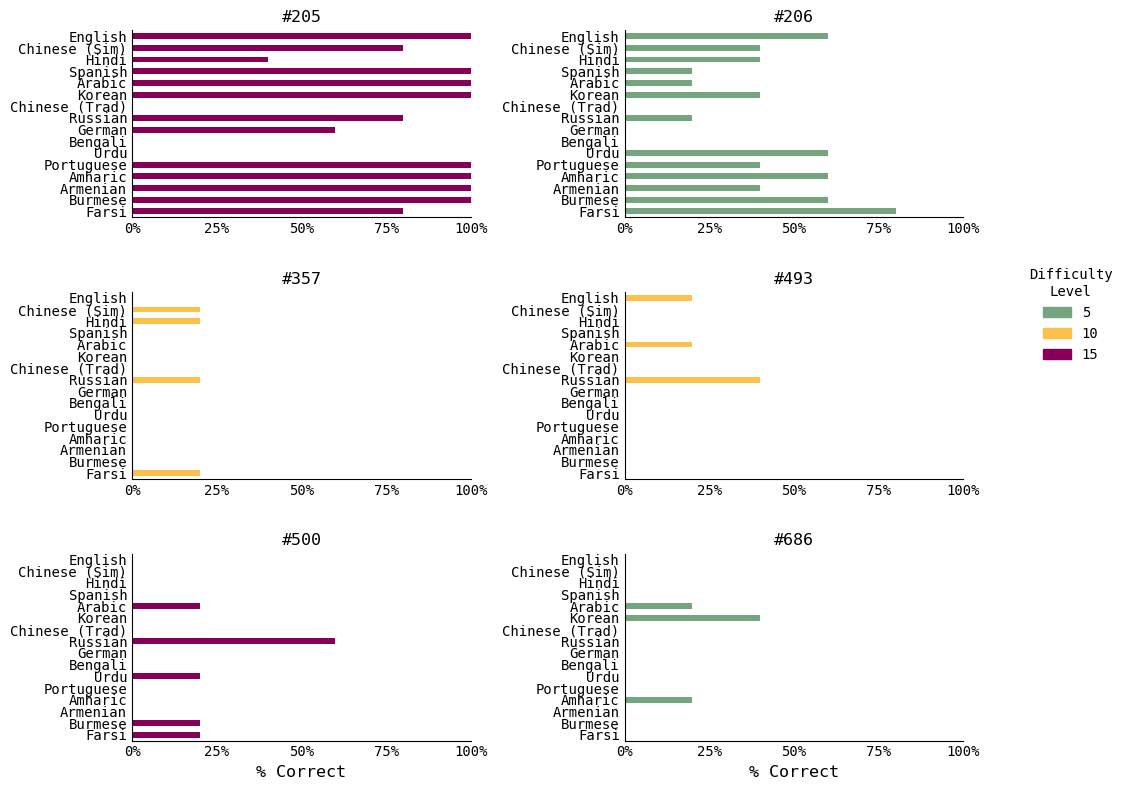

In [29]:


# List of unique languages and qnums
all_languages = df['language'].unique()
all_qnums = sorted([493, 500, 206, 357, 205, 686]) # 1, 3, 

# Filter the dataframe for pass scores
data = df[df.qnum.isin(all_qnums)]
df_pass = data[data['score'] == 'pass']

# Create a figure for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = [i for sublist in axes for i in sublist]
# Color mapping for difficulties

# Create a list of custom patches for the legend
legend_patches = [mpatches.Patch(color=color, label=f"{difficulty}") 
                  for difficulty, color in diff2color.items()]


for idx, q in enumerate(all_qnums):
    ax = axes[idx]
    
    # Create a Series of zeros for all languages
    counts = pd.Series(0, index=all_languages)
    # Update the values with actual counts if the qnum exists in df_pass
    if q in df_pass['qnum'].unique():
        sub_df = df_pass[df_pass['qnum'] == q]
        counts.update(sub_df['language'].value_counts())
        
    
    # Normalize by dividing by 5
    counts = counts / 5
    counts = counts[::-1]
    counts.index = ['Farsi', 'Burmese', 'Armenian', 'Amharic', 'Portuguese', 'Urdu', 
                    'Bengali', 'German', 'Russian', 'Chinese (Trad)', 'Korean', 'Arabic', 
                    'Spanish', 'Hindi', 'Chinese (Sim)', 'English']
    

    difficulty = qnum2difficulty[q]
    color = diff2color[difficulty]
    counts.plot(kind='barh', ax=ax, color=color)
    
    ax.set_title(f'#{q}')
    
    if idx in [4,5]:
        ax.set_xlabel('% Correct', size=12)
    else:
        ax.set_xlabel('')
        
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])  # set x-axis labels as percentages
    
    # Remove spines (borders)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    
    # Remove tickmarks for x and y axes
    ax.tick_params(axis='both', which='both', length=0)

# After your loop, add the legend to your figure
legend=fig.legend(handles=legend_patches, 
           loc='center right', 
           ncol=1, 
           frameon=False,
           title='Difficulty\nLevel',
           bbox_to_anchor=(1.13, 0.6)
          )
legend.get_title().set_horizontalalignment('center')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # adjust this value as necessary
plt.show()

### Back Translation quality and WER

In [33]:
from jiwer import wer

In [34]:
back_trans_df = pd.read_csv('back_trans_df.csv')
back_trans_df['wer'] = None

In [35]:
for qnum in back_trans_df.qnum.unique():
    reference = back_trans_df[(back_trans_df.qnum==qnum) & (back_trans_df.language=='English')]\
                .head(1)\
                .back_translated_q\
                .values[0]\
                .strip()
    
    for i, row in back_trans_df[back_trans_df.qnum==qnum].iterrows():
        hypothesis=row.back_translated_q.strip()
        back_trans_df.loc[i, 'wer'] = wer(reference=reference, hypothesis=hypothesis)

back_trans_df.wer = back_trans_df.wer.astype('float')

In [37]:
data=back_trans_df[back_trans_df.language!='English']

# Calculate the average WER for each language
avg_wer = data.groupby('language')['wer'].median().sort_values()

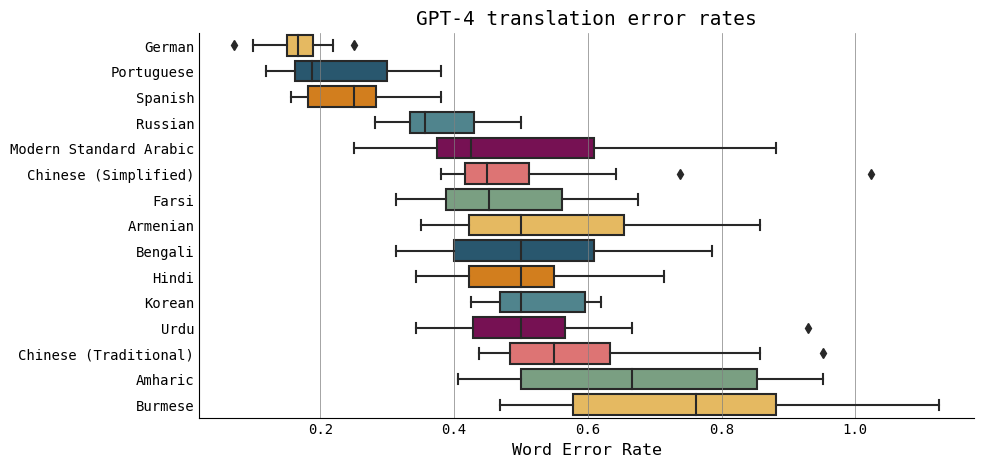

In [41]:
plt.figure(figsize=(10,5))

sns.boxplot(data=data, x='wer', y='language', order=avg_wer.index, palette=COLORS)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.tick_params(axis='both', which='both', length=0)
sns.despine(top=True, right=True)
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='x')
plt.ylabel('')
plt.xlabel('Word Error Rate', size=12)
plt.title('GPT-4 translation error rates', size=14)

plt.show()

### Memorization test

In [42]:
df[(df.qnum.isin(qnums_16_langs)) & (df.response.str.contains('Euler|Эйлер', case=False))]\
    .groupby(['language', 'qnum']).count()

run  translated_q  response  score
language              qnum                                    
Chinese (Traditional) 365     1             1         1      1
English               365     2             2         2      2
                      485     1             1         1      1
Farsi                 485     1             1         1      1
German                485     1             1         1      1
Hindi                 206     1             1         1      1
                      485     2             2         2      2
Russian               365     1             1         1      1
                      485     1             1         1      1

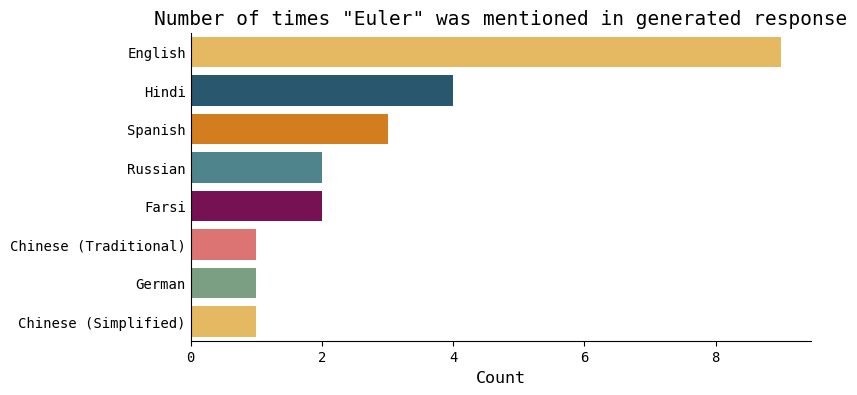

In [44]:
data = df[(df.response.str.contains('Euler|Эйлер', case=False))].language.value_counts().reset_index()
data.columns = ['language', 'count']

plt.figure(figsize=(8,4))
sns.barplot(data=data, x='count', y='language', palette=COLORS)
plt.tick_params(axis='y', which='both', length=0)
plt.ylabel('')
plt.xlabel('Count', size=12)
sns.despine(top=True, right=True)

plt.title('Number of times "Euler" was mentioned in generated response', size=14)
plt.show()